In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import copy
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import json
import os

In [3]:
!pip install  scikit-allel

     |████████████████████████████████| 5.7 MB 4.1 MB/s 


In [4]:
!pip install pyBigWig

     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for pyBigWig: filename=pyBigWig-0.3.18-cp37-cp37m-linux_x86_64.whl size=194119 sha256=4431e9b7f31a51168391abbdc571cd9a6b05f32d5e2d668a4fff2bb57ae19adb
  Stored in directory: /root/.cache/pip/wheels/28/eb/46/c761563ba38bd516bcc6accde3d4188cd84eec067f9201cbec
Successfully built pyBigWig


In [5]:

import allel
import pyBigWig
from google.colab import drive
drive.mount('/content/drive/')

parent_dir_name = 'CS194-172 Final Project'

for dirpath, subdirs, files in os.walk('/content/'):
  if parent_dir_name in subdirs:
    parent_path = dirpath + "/" + parent_dir_name

parent_path

Mounted at /content/drive/


'/content/drive/MyDrive/172/CS194-172 Final Project'

In [6]:
clinvar = allel.vcf_to_dataframe(parent_path + '/clinvar.vcf', fields='*', alt_number=1)
clinvar["variant type"] = clinvar["MC"].apply(lambda row: str(row)[str(row).find("|")+1:])

In [7]:
frameshift = clinvar[(clinvar["variant type"] == "frameshift_variant")]

In [8]:
#Keep pathogenic and benign variants only, assign class label of 1 to pathogenic and 0 to benign
frameshift = frameshift[(frameshift['CLNSIG'] == 'Pathogenic') | (frameshift['CLNSIG'] == 'Benign')]
frameshift['Class label']= np.where(frameshift['CLNSIG']=='Pathogenic', 1, 0)
frameshift_benign = frameshift[frameshift['CLNSIG']== 'Benign'].iloc[:320]
frameshift_pathogenic =frameshift[frameshift['CLNSIG']== 'Pathogenic'].iloc[:320]

In [9]:
frameshift = pd.concat([frameshift_benign, frameshift_pathogenic])

In [10]:
frameshift

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label
5841,1,6469126,1166516,TC,T,NaN,NaN,NaN,NaN,1153648,Distal_spinal_muscular_atrophy,NaN,MONDO:MONDO:0012608,NaN,NC_000001.11:g.6469128del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,Invitae:1614162,NaN,PLEKHG5:57449,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-1,False,frameshift_variant,0
18778,1,26183819,252663,AC,A,NaN,NaN,NaN,NaN,246883,Usher_syndrome,NaN,MONDO:MONDO:0011558,NaN,NC_000001.11:g.26183826del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,CNKSR1:10256,SO:0001589|frameshift_variant,1,781114848,-1,False,1,-1,False,frameshift_variant,0
20089,1,31429409,787526,ACC,A,NaN,NaN,NaN,NaN,707340,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.31429413_31429414del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,SERINC2:347735|LOC110594336:110594336,SO:0001589|frameshift_variant,1,545630463,-1,False,1,-2,False,frameshift_variant,0
20669,1,34761404,195421,CT,C,NaN,NaN,NaN,NaN,192582,not_specified|not_provided,NaN,MedGen:CN169374|MedGen:CN517202,NaN,NC_000001.11:g.34761407del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4:127534,SO:0001589|frameshift_variant,1,139849901,-1,False,1,-1,False,frameshift_variant,0
20670,1,34761406,1276227,TTGTC,T,NaN,NaN,NaN,NaN,1268855,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.34761409_34761412del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4:127534,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-4,False,frameshift_variant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19775,1,27550234,208156,AC,A,NaN,NaN,NaN,NaN,204417,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550235del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1:27245,SO:0001589|frameshift_variant,1,796065040,-1,False,1,-1,False,frameshift_variant,1
19779,1,27550297,1164008,CGTTGG,A,NaN,NaN,NaN,NaN,1153010,Xia-Gibbs_syndrome,NaN,MONDO:MONDO:0014358,NaN,NC_000001.11:g.27550297_27550302delinsA,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Indel,SO:1000032,NaN,NaN,AHDC1:27245,SO:0001589|frameshift_variant,32,NaN,-1,False,1,-5,False,frameshift_variant,1
19781,1,27550305,451608,TC,T,NaN,NaN,NaN,NaN,442816,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550306del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1:27245,SO:0001589|frameshift_variant,1,1553159284,-1,False,1,-1,False,frameshift_variant,1
19783,1,27550357,816930,G,GT,NaN,NaN,NaN,NaN,805074,Neurodevelopmental_abnormality|Xia-Gibbs_syndr...,NaN,Human_Phenotype_Ontology:HP:0012759,NaN,NC_000001.11:g.27550364dup,criteria_provided,Pathogenic,NaN,NaN,Duplication,SO:1000035,Invitae:5874535|Genomic_Medicine_Lab,NaN,AHDC1:27245,SO:0001589|frameshift_variant,33,1064797043,-1,False,1,1,False,frameshift_variant,1


**Part 1: Features Selection** 
- RVIS Score
-PhastCons Value 
-O/E Value 
-Exac_pLI Value 
-Xpresso
-GDI Index
-CADD Score

**RVIS Score**



In [11]:
#Read data set and drop unnecessary columns 
rvis_data = pd.read_csv(parent_path + '/RVIS_Unpublished_ExACv2_March2017.txt', delimiter="\t")
rvis_data = rvis_data.drop(columns=['%geneCov', 'RVIS[pop_maf_0.05%(any)]', 'Edge_case_RVIS[pop_maf_0.05%(any)]', 'OE-ratio_[ExAC v2]', 'alternative-RVIS[maf_0.0025%]', 'alternative-%RVIS[maf_0.0025%]', '%OE-ratio_[ExAC v2]'])
rvis_data = rvis_data.set_index("CCDSr20")

#Clean up GENEINFO column to merge rviz values 
frameshift['GENEINFO'] = frameshift['GENEINFO'].str.replace(':', ' ')
frameshift['GENEINFO'] = frameshift['GENEINFO'].str.replace('|', ' ')
frameshift[['GENE1', 'NUM1', 'GENE2', 'NUM2']] =  frameshift['GENEINFO'].str.split(' ', 3, expand=True)

frameshift = pd.merge(frameshift, rvis_data, left_on="GENE1", right_on="CCDSr20", how="left")
frameshift['%RVIS[pop_maf_0.05%(any)]'] = frameshift['%RVIS[pop_maf_0.05%(any)]'].replace(np.nan, 50)
frameshift= frameshift.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "first rvis"})
frameshift = pd.merge(frameshift, rvis_data, left_on="GENE2", right_on="CCDSr20", how="left")
frameshift= frameshift.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "second rvis"})
frameshift["second rvis"] = frameshift[frameshift['GENE2'].values != None]["second rvis"].replace(np.nan, 50)

#Take average of gene1 and gene2 rvis values 
frameshift["mean RVIS score"] =  frameshift[["first rvis", "second rvis"]].mean(axis=1)


Text(0.5, 1.0, 'RVIS')

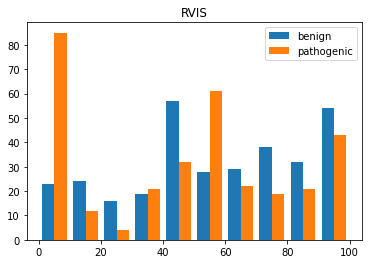

In [12]:
#plot histogram 
pathogenic = frameshift[frameshift['Class label']== 1]
benign = frameshift[frameshift['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['mean RVIS score'], pathogenic['mean RVIS score']], label=names)
plt.legend()
plt.title("RVIS")

**PhastCons Value**

In [13]:
#Extract phastCons data and append it to variants
phastcons_data = pyBigWig.open(parent_path + "/hg38.phastCons100way.bw")
frameshift["phastCons"] = [phastcons_data.stats("chr" + x, y, y+1) for x, y in zip(frameshift["CHROM"],frameshift["POS"])]
frameshift["phastCons"] = frameshift["phastCons"].str[0]

Text(0.5, 1.0, 'PhastCons')

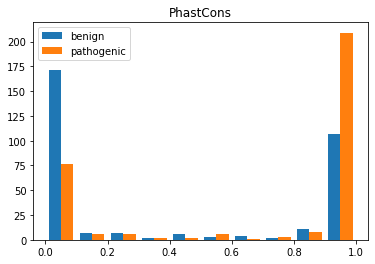

In [14]:
#Plot a histogram
pathogenic = frameshift[frameshift['Class label']== 1]
benign = frameshift[frameshift['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['phastCons'], pathogenic['phastCons']], label=names)
plt.legend()
plt.title("PhastCons")

**O/E Value and 
Exac_pLI Value**

In [15]:
#Extract gnomad data and append values to variants
gnomad_data = pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
frameshift = pd.merge(frameshift, gnomad_data, left_on="GENE1", right_on="gene", how="left")
frameshift["oe_lof_upper_rank"] = frameshift["oe_lof_upper_rank"].replace(np.nan, frameshift["oe_lof_upper_rank"].max()/2)
frameshift["exac_pLI"] = frameshift["exac_pLI"].replace(np.nan, frameshift["exac_pLI"].max()/2)


In [16]:
pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')


,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,possible_mis_pphen,obs_syn,exp_syn,oe_syn,mu_syn,possible_syn,obs_lof,mu_lof,possible_lof,exp_lof,pLI,pNull,pRec,oe_lof,oe_syn_lower,oe_syn_upper,oe_mis_lower,oe_mis_upper,oe_lof_lower,oe_lof_upper,constraint_flag,syn_z,mis_z,lof_z,oe_lof_upper_rank,oe_lof_upper_bin,oe_lof_upper_bin_6,n_sites,classic_caf,max_af,no_lofs,obs_het_lof,obs_hom_lof,defined,p,exp_hom_lof,classic_caf_afr,classic_caf_amr,classic_caf_asj,classic_caf_eas,classic_caf_fin,classic_caf_nfe,classic_caf_oth,classic_caf_sas,p_afr,p_amr,p_asj,p_eas,p_fin,p_nfe,p_oth,p_sas,transcript_type,gene_id,transcript_level,cds_length,num_coding_exons,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,6708.0,422,387.530,1.08900,0.000019,4248,0.0,0.000005,1257.0,98.429,1.0,8.943600e-40,1.838300e-16,0.000000,1.005,1.180,0.736,0.824,0.000,0.030,NaN,-1.376500,2.623200,9.1935,0.0,0.0,0.0,2.0,0.000012,0.000008,124782.0,3.0,0.0,124785.0,0.000012,0.000018,0.000000,0.000000,0.000000,0.000000,0.000093,0.000009,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000009,0.0,0.000000,protein_coding,ENSG00000108510,2,6522,30,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,7135.0,496,495.010,1.00200,0.000025,5211,1.0,0.000009,1781.0,150.320,1.0,2.977300e-59,3.572400e-24,0.006653,0.930,1.079,0.554,0.621,0.001,0.032,NaN,-0.035119,5.573700,11.2860,1.0,0.0,0.0,2.0,0.000012,0.000008,125693.0,3.0,0.0,125696.0,0.000012,0.000018,0.000000,0.000000,0.000099,0.000000,0.000000,0.000000,0.0,0.000065,0.000000,0.000000,0.000099,0.000000,0.000000,0.000000,0.0,0.000065,protein_coding,ENSG00000164190,2,8412,46,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,2197.0,215,203.250,1.05780,0.000010,2091,0.0,0.000005,937.0,79.490,1.0,2.785300e-32,2.191400e-13,0.000000,0.946,1.184,0.249,0.320,0.000,0.037,NaN,-0.647760,6.399900,8.2618,2.0,0.0,0.0,8.0,0.000032,0.000004,125731.0,8.0,0.0,125739.0,0.000032,0.000127,0.000000,0.000000,0.000099,0.000054,0.000000,0.000044,0.0,0.000033,0.000000,0.000000,0.000099,0.000054,0.000000,0.000044,0.0,0.000033,protein_coding,ENSG00000108055,2,3651,29,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,3560.0,470,456.030,1.03060,0.000024,4564,1.0,0.000007,1440.0,125.030,1.0,2.992400e-49,4.562900e-20,0.007998,0.955,1.112,0.403,0.464,0.002,0.038,NaN,-0.514100,7.254600,10.2790,3.0,0.0,0.0,5.0,0.000020,0.000004,125740.0,4.0,0.0,125744.0,0.000016,0.000032,0.000000,0.000029,0.000000,0.000055,0.000000,0.000026,0.0,0.000000,0.000000,0.000029,0.000000,0.000054,0.000000,0.000018,0.0,0.000000,protein_coding,ENSG00000125107,2,7128,48,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,4151.0,358,352.620,1.01530,0.000017,3482,0.0,0.000004,1024.0,73.222,1.0,8.405500e-30,2.284200e-12,0.000000,0.930,1.108,0.645,0.733,0.000,0.040,NaN,-0.225180,3.462000,7.9294,4.0,0.0,0.0,1.0,0.000004,0.000004,125122.0,1.0,0.0,125123.0,0.000004,0.000002,0.000062,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000062,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,protein_coding,ENSG00000117000,2,5742,8,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [18]:
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
frameshift = pd.merge(frameshift, gnomad_data, left_on="GENE1", right_on="gene", how="left")
frameshift["oe_lof_upper_rank"] = frameshift["oe_lof_upper_rank"].replace(np.nan, frameshift["oe_lof_upper_rank"].max()/2)
frameshift["exac_pLI"] = frameshift["exac_pLI"].replace(np.nan, frameshift["exac_pLI"].max()/2)

In [19]:
frameshift

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI
0,1,6469126,1166516,TC,T,NaN,NaN,NaN,NaN,1153648,Distal_spinal_muscular_atrophy,NaN,MONDO:MONDO:0012608,NaN,NC_000001.11:g.6469128del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,Invitae:1614162,NaN,PLEKHG5 57449,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-1,False,frameshift_variant,0,PLEKHG5,57449,None,None,93.929619,NaN,93.929619,1.000,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05
1,1,26183819,252663,AC,A,NaN,NaN,NaN,NaN,246883,Usher_syndrome,NaN,MONDO:MONDO:0011558,NaN,NC_000001.11:g.26183826del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,CNKSR1 10256,SO:0001589|frameshift_variant,1,781114848,-1,False,1,-1,False,frameshift_variant,0,CNKSR1,10256,None,None,85.972630,NaN,85.972630,0.000,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16
2,1,31429409,787526,ACC,A,NaN,NaN,NaN,NaN,707340,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.31429413_31429414del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,SERINC2 347735 LOC110594336 110594336,SO:0001589|frameshift_variant,1,545630463,-1,False,1,-2,False,frameshift_variant,0,SERINC2,347735,LOC110594336,110594336,86.881720,50.0,68.440860,1.000,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06
3,1,34761404,195421,CT,C,NaN,NaN,NaN,NaN,192582,not_specified|not_provided,NaN,MedGen:CN169374|MedGen:CN517202,NaN,NC_000001.11:g.34761407del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,139849901,-1,False,1,-1,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,1.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06
4,1,34761406,1276227,TTGTC,T,NaN,NaN,NaN,NaN,1268855,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.34761409_34761412del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-4,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,0.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1,27550234,208156,AC,A,NaN,NaN,NaN,NaN,204417,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550235del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,796065040,-1,False,1,-1,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.965,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01
636,1,27550297,1164008,CGTTGG,A,NaN,NaN,NaN,NaN,1153010,Xia-Gibbs_syndrome,NaN,MONDO:MONDO:0014358,NaN,NC_000001.11:g.27550297_27550302delinsA,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Indel,SO:1000032,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,32,NaN,-1,False,1,-5,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.427,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01
637,1,27550305,451608,TC,T,NaN,NaN,NaN,NaN,442816,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550306del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,1553159284,-1,False,1,-1,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,1.000,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994

Text(0.5, 1.0, 'O/E')

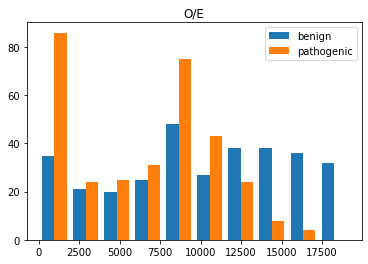

In [20]:
#Plot histograms
pathogenic = frameshift[frameshift['Class label']== 1]
benign = frameshift[frameshift['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['oe_lof_upper_rank'], pathogenic['oe_lof_upper_rank']], label=names)
plt.legend()
plt.title("O/E")


Text(0.5, 1.0, 'exac_pLI')

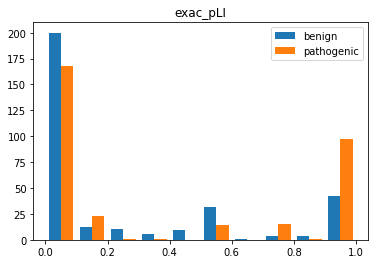

In [21]:
#Plot histograms
pathogenic = frameshift[frameshift['Class label']== 1]
benign = frameshift[frameshift['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign["exac_pLI"], pathogenic["exac_pLI"]], label=names)
plt.legend()
plt.title("exac_pLI")

In [22]:
frameshift

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI
0,1,6469126,1166516,TC,T,NaN,NaN,NaN,NaN,1153648,Distal_spinal_muscular_atrophy,NaN,MONDO:MONDO:0012608,NaN,NC_000001.11:g.6469128del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,Invitae:1614162,NaN,PLEKHG5 57449,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-1,False,frameshift_variant,0,PLEKHG5,57449,None,None,93.929619,NaN,93.929619,1.000,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05
1,1,26183819,252663,AC,A,NaN,NaN,NaN,NaN,246883,Usher_syndrome,NaN,MONDO:MONDO:0011558,NaN,NC_000001.11:g.26183826del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,CNKSR1 10256,SO:0001589|frameshift_variant,1,781114848,-1,False,1,-1,False,frameshift_variant,0,CNKSR1,10256,None,None,85.972630,NaN,85.972630,0.000,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16
2,1,31429409,787526,ACC,A,NaN,NaN,NaN,NaN,707340,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.31429413_31429414del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,SERINC2 347735 LOC110594336 110594336,SO:0001589|frameshift_variant,1,545630463,-1,False,1,-2,False,frameshift_variant,0,SERINC2,347735,LOC110594336,110594336,86.881720,50.0,68.440860,1.000,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06
3,1,34761404,195421,CT,C,NaN,NaN,NaN,NaN,192582,not_specified|not_provided,NaN,MedGen:CN169374|MedGen:CN517202,NaN,NC_000001.11:g.34761407del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,139849901,-1,False,1,-1,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,1.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06
4,1,34761406,1276227,TTGTC,T,NaN,NaN,NaN,NaN,1268855,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.34761409_34761412del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-4,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,0.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1,27550234,208156,AC,A,NaN,NaN,NaN,NaN,204417,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550235del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,796065040,-1,False,1,-1,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.965,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01
636,1,27550297,1164008,CGTTGG,A,NaN,NaN,NaN,NaN,1153010,Xia-Gibbs_syndrome,NaN,MONDO:MONDO:0014358,NaN,NC_000001.11:g.27550297_27550302delinsA,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Indel,SO:1000032,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,32,NaN,-1,False,1,-5,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.427,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01
637,1,27550305,451608,TC,T,NaN,NaN,NaN,NaN,442816,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550306del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,1553159284,-1,False,1,-1,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,1.000,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994

**Gene Expression Level**

In [23]:
# from Xpresso dataset
# read by default 1st sheet of an excel file
dataframe1 = pd.read_excel(parent_path + "/xpresso.xlsx")
Xpresso = dataframe1[['Unnamed: 1', 'Unnamed: 63']][2:]
Xpresso = Xpresso.rename(columns={'Unnamed: 1':"Gene Name", 'Unnamed: 63':"Median expression" })[1:]
frameshift = pd.merge(frameshift, Xpresso, left_on="GENE1", right_on="Gene Name", how="left")
frameshift["Median expression"] = frameshift["Median expression"].replace(np.nan, 0)
frameshift = frameshift.rename(columns = {"Median expression": "median_expression_level_1"})

frameshift = pd.merge(frameshift, Xpresso, left_on="GENE2", right_on="Gene Name", how="left")
frameshift["Median expression"] = frameshift[frameshift['GENE2'].values != None]["Median expression"].replace(np.nan, 0)
frameshift = frameshift.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
frameshift["mean gene_expression_level"] =  frameshift[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
frameshift = frameshift.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


In [24]:
frameshift

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI,mean gene_expression_level
0,1,6469126,1166516,TC,T,NaN,NaN,NaN,NaN,1153648,Distal_spinal_muscular_atrophy,NaN,MONDO:MONDO:0012608,NaN,NC_000001.11:g.6469128del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,Invitae:1614162,NaN,PLEKHG5 57449,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-1,False,frameshift_variant,0,PLEKHG5,57449,None,None,93.929619,NaN,93.929619,1.000,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05,0.7620
1,1,26183819,252663,AC,A,NaN,NaN,NaN,NaN,246883,Usher_syndrome,NaN,MONDO:MONDO:0011558,NaN,NC_000001.11:g.26183826del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,CNKSR1 10256,SO:0001589|frameshift_variant,1,781114848,-1,False,1,-1,False,frameshift_variant,0,CNKSR1,10256,None,None,85.972630,NaN,85.972630,0.000,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16,0.4740
2,1,31429409,787526,ACC,A,NaN,NaN,NaN,NaN,707340,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.31429413_31429414del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,SERINC2 347735 LOC110594336 110594336,SO:0001589|frameshift_variant,1,545630463,-1,False,1,-2,False,frameshift_variant,0,SERINC2,347735,LOC110594336,110594336,86.881720,50.0,68.440860,1.000,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06,0.6315
3,1,34761404,195421,CT,C,NaN,NaN,NaN,NaN,192582,not_specified|not_provided,NaN,MedGen:CN169374|MedGen:CN517202,NaN,NC_000001.11:g.34761407del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,139849901,-1,False,1,-1,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,1.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,-0.9360
4,1,34761406,1276227,TTGTC,T,NaN,NaN,NaN,NaN,1268855,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.34761409_34761412del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-4,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,0.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,-0.9360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1,27550234,208156,AC,A,NaN,NaN,NaN,NaN,204417,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550235del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,796065040,-1,False,1,-1,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.965,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,1.0370
636,1,27550297,1164008,CGTTGG,A,NaN,NaN,NaN,NaN,1153010,Xia-Gibbs_syndrome,NaN,MONDO:MONDO:0014358,NaN,NC_000001.11:g.27550297_27550302delinsA,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Indel,SO:1000032,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,32,NaN,-1,False,1,-5,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.427,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,1.0370
637,1,27550305,451608,TC,T,NaN,NaN,NaN,NaN,442816,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550306del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,1553159284,-1,False,1,-1,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,N

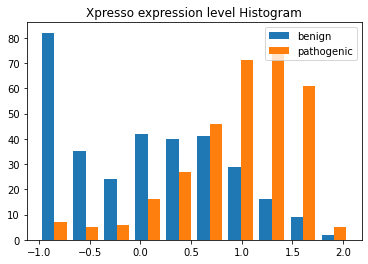

In [25]:
plt.hist([frameshift[frameshift["Class label"] == 0 ]["mean gene_expression_level"],frameshift[frameshift["Class label"] == 1 ]["mean gene_expression_level"]], label = ["benign", "pathogenic"])  
plt.title('Xpresso expression level Histogram')


plt.legend(loc='upper right')

**GDI Index**

In [26]:
import re
gdi_data = pd.read_csv(parent_path + "/GDI_full.txt",  delimiter="\t")
gdi_data = gdi_data[["Gene", "GDI-Phred"]]
gdi_data = gdi_data.rename(columns={"Gene": "Gene Name", "GDI-Phred":"Median expression"})


frameshift = pd.merge(frameshift, gdi_data, left_on="GENE1", right_on="Gene Name", how="left")
frameshift["Median expression"] = frameshift["Median expression"].replace(np.nan, frameshift["Median expression"].max()/2)
frameshift = frameshift.rename(columns = {"Median expression": "median_expression_level_1"})

frameshift = pd.merge(frameshift, gdi_data, left_on="GENE2", right_on="Gene Name", how="left")
frameshift["Median expression"] = frameshift[frameshift['GENE2'].values != None]["Median expression"].replace(np.nan, frameshift["Median expression"].max()/2)
frameshift = frameshift.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
frameshift["GDI"] =  frameshift[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
frameshift = frameshift.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


In [27]:
frameshift

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,variant type,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,oe_lof_upper_rank_x,exac_pLI_x,gene_y,oe_lof_upper_rank_y,exac_pLI_y,gene,oe_lof_upper_rank,exac_pLI,mean gene_expression_level,GDI
0,1,6469126,1166516,TC,T,NaN,NaN,NaN,NaN,1153648,Distal_spinal_muscular_atrophy,NaN,MONDO:MONDO:0012608,NaN,NC_000001.11:g.6469128del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,Invitae:1614162,NaN,PLEKHG5 57449,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-1,False,frameshift_variant,0,PLEKHG5,57449,None,None,93.929619,NaN,93.929619,1.000,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05,PLEKHG5,5599.0,4.028200e-05,0.7620,9.879120
1,1,26183819,252663,AC,A,NaN,NaN,NaN,NaN,246883,Usher_syndrome,NaN,MONDO:MONDO:0011558,NaN,NC_000001.11:g.26183826del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,CNKSR1 10256,SO:0001589|frameshift_variant,1,781114848,-1,False,1,-1,False,frameshift_variant,0,CNKSR1,10256,None,None,85.972630,NaN,85.972630,0.000,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16,CNKSR1,13755.0,3.790500e-16,0.4740,5.601390
2,1,31429409,787526,ACC,A,NaN,NaN,NaN,NaN,707340,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.31429413_31429414del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,SERINC2 347735 LOC110594336 110594336,SO:0001589|frameshift_variant,1,545630463,-1,False,1,-2,False,frameshift_variant,0,SERINC2,347735,LOC110594336,110594336,86.881720,50.0,68.440860,1.000,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06,SERINC2,13425.0,1.033700e-06,0.6315,6.959495
3,1,34761404,195421,CT,C,NaN,NaN,NaN,NaN,192582,not_specified|not_provided,NaN,MedGen:CN169374|MedGen:CN517202,NaN,NC_000001.11:g.34761407del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,139849901,-1,False,1,-1,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,1.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,-0.9360,7.853610
4,1,34761406,1276227,TTGTC,T,NaN,NaN,NaN,NaN,1268855,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.34761409_34761412del,criteria_provided,Benign,NaN,NaN,Deletion,SO:0000159,NaN,NaN,GJB4 127534,SO:0001589|frameshift_variant,1,NaN,-1,False,1,-4,False,frameshift_variant,0,GJB4,127534,None,None,96.627566,NaN,96.627566,0.000,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,GJB4,17102.0,1.964800e-06,-0.9360,7.853610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1,27550234,208156,AC,A,NaN,NaN,NaN,NaN,204417,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550235del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,796065040,-1,False,1,-1,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.965,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,1.0370,4.747520
636,1,27550297,1164008,CGTTGG,A,NaN,NaN,NaN,NaN,1153010,Xia-Gibbs_syndrome,NaN,MONDO:MONDO:0014358,NaN,NC_000001.11:g.27550297_27550302delinsA,no_assertion_criteria_provided,Pathogenic,NaN,NaN,Indel,SO:1000032,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,32,NaN,-1,False,1,-5,False,frameshift_variant,1,AHDC1,27245,None,None,2.658847,NaN,2.658847,0.427,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,AHDC1,84.0,9.994300e-01,1.0370,4.747520
637,1,27550305,451608,TC,T,NaN,NaN,NaN,NaN,442816,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.27550306del,criteria_provided,Pathogenic,NaN,NaN,Deletion,SO:0000159,NaN,NaN,AHDC1 27245,SO:0001589|frameshift_variant,1,1553159284,-1

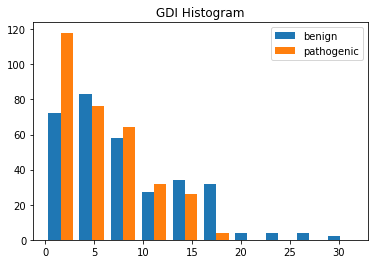

In [28]:
plt.hist([frameshift[frameshift["Class label"] == 0 ]["GDI"],frameshift[frameshift["Class label"] == 1 ]["GDI"]], label = ["benign", "pathogenic"])  
plt.title('GDI Histogram')


plt.legend(loc='upper right')

**CADD**

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)

In [ ]:
frameshift

1. Create gzipped vcf file, with proper format and without extra data for speed

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)

new = frameshift
# new["ALT length"] = new['ALT'].apply(lambda r: len(str(r)))
# new["REF length"] = new['REF'].apply(lambda r: len(str(r)))
# new = new[(new["ALT length"]==1)]
# new = new[(new["REF length"]==1)]


new = new[["CHROM", "POS", "ID", "REF", "ALT"]]
# new["ALT"] = new["ALT"].apply(lambda row: row[0])
header = """##fileformat=VCFv4.1
#CHROM POS ID REF ALT
"""

output_VCF = "frameshift_data.vcf"
with open(output_VCF, 'w') as vcf:
    vcf.write(header)

new.to_csv(output_VCF, sep="\t", mode='a', index=False)

# import gzip
# import shutil
# with open('file.txt', 'rb') as f_in:
#     with gzip.open('file.txt.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)


# turn in to # https://cadd.gs.washington.edu/score with ANNOTATIONS selected

2.Upload to https://cadd.gs.washington.edu/score **with ANNOTATIONS selected**
and cadd model GRCh38-v1.6

---



3. Upload resulting file to folder, below code reads as df

In [29]:
import gzip
with gzip.open(parent_path +'/frameshift_cadd.tsv.gz', 'rt') as f:
  # with gzip.open('chr22_subsampled_snps.vcf.gz', 'rt') as f:
  lines = f.readlines()
  with open('caddunzipped.txt', 'w') as t:
    for line in lines[1:]:
        t.write(line)
        t.write('\n')
cadd_data = pd.read_csv('caddunzipped.txt', delimiter="\t")
cadd_data = cadd_data.rename(columns={"PHRED": "CADD_score"})

In [30]:
cadd_data

,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,ConsDetail,GC,CpG,motifECount,motifEName,motifEHIPos,motifEScoreChng,oAA,nAA,GeneID,FeatureID,GeneName,CCDS,Intron,Exon,cDNApos,relcDNApos,CDSpos,relCDSpos,protPos,relProtPos,Domain,Dst2Splice,Dst2SplType,minDistTSS,minDistTSE,SIFTcat,SIFTval,PolyPhenCat,PolyPhenVal,priPhCons,...,EncodeH3K27me3-max,EncodeH3K36me3-sum,EncodeH3K36me3-max,EncodeH3K79me2-sum,EncodeH3K79me2-max,EncodeH4K20me1-sum,EncodeH4K20me1-max,EncodeH2AFZ-sum,EncodeH2AFZ-max,EncodeDNase-sum,EncodeDNase-max,EncodetotalRNA-sum,EncodetotalRNA-max,Grantham,SpliceAI-acc-gain,SpliceAI-acc-loss,SpliceAI-don-gain,SpliceAI-don-loss,MMSp_acceptorIntron,MMSp_acceptor,MMSp_exon,MMSp_donor,MMSp_donorIntron,Dist2Mutation,Freq100bp,Rare100bp,Sngl100bp,Freq1000bp,Rare1000bp,Sngl1000bp,Freq10000bp,Rare10000bp,Sngl10000bp,EnsembleRegulatoryFeature,dbscSNV-ada_score,dbscSNV-rf_score,RemapOverlapTF,RemapOverlapCL,RawScore,CADD_score
0,1,1014316,C,CG,INS,1,CodingTranscript,FRAME_SHIFT,7,frameshift,0.647,0.121,NaN,NaN,NaN,NaN,-,X,ENSG00000187608,ENST00000379389,ISG15,CCDS6.1,NaN,2/2,487.0,0.685,336.0,0.675,112.0,0.679,ndomain,NaN,NaN,819,119,NaN,NaN,NaN,NaN,0.002,...,0.85,5.84,1.13,45.84,16.75,9.72,2.42,56.94,15.78,0.98,0.20,18.40,10.94,NaN,0.0,0.00,0.01,0.0,0.0,0.0,-0.026,0.0,0.0,24,1.0,0.0,26.0,4,9,209,21,88,1626,Promoter,NaN,NaN,72.0,91.0,2.797822,23.00
1,1,1014316,C,CG,INS,1,Intergenic,UPSTREAM,1,upstream,0.647,0.121,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000224969,ENST00000458555,AL645608.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819,119,NaN,NaN,NaN,NaN,0.002,...,0.85,5.84,1.13,45.84,16.75,9.72,2.42,56.94,15.78,0.98,0.20,18.40,10.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,1.0,0.0,26.0,4,9,209,21,88,1626,Promoter,NaN,NaN,72.0,91.0,2.797822,23.00
2,1,1014316,C,CG,INS,1,RegulatoryFeature,REGULATORY,4,regulatory,0.647,0.121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSR00000000122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819,119,NaN,NaN,NaN,NaN,0.002,...,0.85,5.84,1.13,45.84,16.75,9.72,2.42,56.94,15.78,0.98,0.20,18.40,10.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,1.0,0.0,26.0,4,9,209,21,88,1626,Promoter,NaN,NaN,72.0,91.0,2.797822,23.00
3,1,1014316,C,CG,INS,1,RegulatoryFeature,REGULATORY,4,regulatory,0.647,0.121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSR00000344455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819,119,NaN,NaN,NaN,NaN,0.002,...,0.85,5.84,1.13,45.84,16.75,9.72,2.42,56.94,15.78,0.98,0.20,18.40,10.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,1.0,0.0,26.0,4,9,209,21,88,1626,Promoter,NaN,NaN,72.0,91.0,2.797822,23.00
4,1,1040694,G,GC,INS,1,CodingTranscript,FRAME_SHIFT,7,frameshift,0.733,0.255,NaN,NaN,NaN,NaN,A,AX,ENSG00000188157,ENST00000379370,AGRN,CCDS30551.1,NaN,4/36,591.0,0.081,541.0,0.088,181.0,0.089,ndomain,NaN,NaN,5827,31,NaN,NaN,NaN,NaN,0.676,...,14.80,3.69,1.62,14.00,3.96,26.78,8.26,68.85,12.53,4.56,2.02,19.26,12.25,NaN,0.0,0.03,0.00,0.0,0.0,0.0,-0.286,0.0,0.0,16,0.0,1.0,20.0,1,10,141,25,104,1890,Promoter,NaN,NaN,128.0,225.0,4.979811,33.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,X,134245653,CT,C,DEL,1,CodingTranscript,FRAME_SHIFT,7,frameshift,0.371,0.027,NaN,NaN,NaN,NaN,L,X,ENSG00000203952,ENST00000517294,CCDC160,CCDS48171.1,NaN,3/3,1237.0,0.691,854.0,0.873,285.0,0.877,hmmpanther,NaN,NaN,8607,125,NaN,NaN,NaN,NaN,0.078,...,3.89,2.02,0.62,3.50,1.42,3.47,0.82,10.05,3.11,0.12,0.02,0.00,0.00,NaN,0.0,0.00,0.00,0.0,0.0,0.0,0.011,0.0,0.0,16,0.0,0.0,13.0,0,1,83,4,28,849,NaN,NaN,NaN,NaN,NaN,2.985287,23.40
1210,X,141879368,GCTACACCCTTTCCCTTC,G,DEL,17,CodingTranscript,FRAME_SHIFT,7,frameshift,0.575,0.048,NaN,NaN,NaN,NaN,GYTLSLP,GX,ENSG00000165509,ENST00000298296,MAGEC3,CCDS14676.1,NaN,3/8,453.0,0.234,453.0,0.234,151.0,0.235,hm

In [31]:
cadd_data = cadd_data.drop_duplicates(
  subset = ['#Chrom', 'Pos'],
  keep = 'last').reset_index(drop = True)
cadd_data["#Chrom"] = cadd_data["#Chrom"].apply(lambda r:str(r))

cadd_columns = ["CADD_score"]
cadd_data = cadd_data[["#Chrom", "Pos"]+cadd_columns]
cadd_frameshift_merged = pd.merge(left = frameshift, right = cadd_data, left_on = ["CHROM", "POS"], right_on=["#Chrom", "Pos"],how="left")
for col in cadd_columns:
  cadd_frameshift_merged[col] = cadd_frameshift_merged[col].replace(np.nan, cadd_frameshift_merged[col].max()/2) 

frameshift = cadd_frameshift_merged.drop(columns =["#Chrom", "Pos"])

  

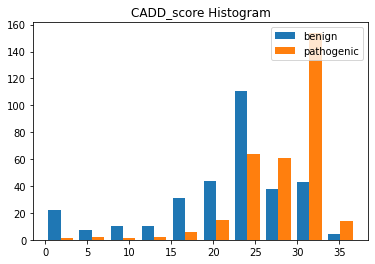

In [32]:
plt.hist([frameshift[frameshift["Class label"] == 0 ]["CADD_score"],frameshift[frameshift["Class label"] == 1 ]["CADD_score"]], label = ["benign", "pathogenic"])  
plt.title("CADD_score Histogram")


plt.legend(loc='upper right')

Training of Model

In [33]:
frameshift.columns
c =["CHROM", "POS", "Class label", "mean RVIS score", "phastCons", "oe_lof_upper_rank", "exac_pLI", "GDI", "CADD_score", "mean gene_expression_level"]
for val in c:
  if val not in frameshift.columns:
    print(val)

In [34]:
frameshift_data = frameshift[c]

In [35]:
frameshift_data

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score,mean gene_expression_level
0,1,6469126,0,93.929619,1.000,5599.0,4.028200e-05,9.879120,25.90,0.7620
1,1,26183819,0,85.972630,0.000,13755.0,3.790500e-16,5.601390,18.03,0.4740
2,1,31429409,0,68.440860,1.000,13425.0,1.033700e-06,6.959495,33.00,0.6315
3,1,34761404,0,96.627566,1.000,17102.0,1.964800e-06,7.853610,29.40,-0.9360
4,1,34761406,0,96.627566,0.000,17102.0,1.964800e-06,7.853610,21.80,-0.9360
...,...,...,...,...,...,...,...,...,...,...
635,1,27550234,1,2.658847,0.965,84.0,9.994300e-01,4.747520,24.10,1.0370
636,1,27550297,1,2.658847,0.427,84.0,9.994300e-01,4.747520,32.00,1.0370
637,1,27550305,1,2.658847,1.000,84.0,9.994300e-01,4.747520,25.00,1.0370
638,1,27550357,1,2.658847,0.072,84.0,9.994300e-01,4.747520,28.60,1.0370


In [36]:
training_set, validation_set= train_test_split(frameshift_data, test_size=0.2)

In [ ]:
training_set

In [ ]:
validation_set

In [37]:
X_train = training_set.drop(columns=["Class label", "CHROM", "POS"])
Y_train = training_set.loc[:, training_set.columns.intersection(['Class label'])]
X_test = validation_set.drop(columns=["Class label", "CHROM", "POS"])
Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]

In [38]:
estimators = [50, 100, 150, 200, 250, 300, 350]
kf =KFold(n_splits=5, shuffle=True, random_state=42)
for count in estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= count, random_state= 42), X_train, Y_train, cv= kf, scoring= "accuracy")
    print(f'For estimators: {count}')
    print(score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 50
0.8944222349133829


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 100
0.8866171711403009


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 150
0.8885589187131163


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 200
0.8865981343993908


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 250
0.8885779554540264


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 300
0.8905387397677519


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 350
0.8885779554540264


In [39]:
model = RandomForestClassifier(n_estimators= 50)

In [40]:
model.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(n_estimators=50)

In [41]:

Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]
accuracy_score(model.predict(X_test), Y_test)

0.8984375

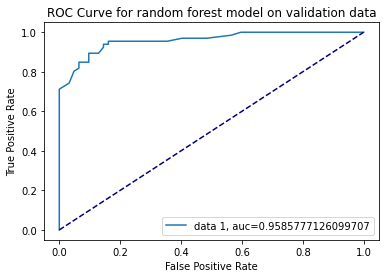

In [42]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color="navy",linestyle="--")
plt.title("ROC Curve for random forest model on validation data")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

**Exporting Validation Set as CSV to try INTRON variant model on frameshift variants to see if model learnings are transferable across varaint types**


In [48]:
export_frameshift_x_test = X_test.drop(columns = ["mean gene_expression_level"])
export_frameshift_x_test.to_csv("export_frameshift_x_test.csv", sep='\t')


In [49]:
export_frameshift_y_test = Y_test
export_frameshift_y_test.to_csv("export_frameshift_y_test.csv", sep='\t')
